In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Excercise:

We will be interested in solving heat equation:

\begin{align*}
    u_t - \kappa \Delta u &= f
        &&\quad\text{ in }\Omega\times(0, T),\tag{1}\\
     u &= u_D
        &&\quad\text{ on }\partial\Omega\times(0, T),\tag{2}\\
    u &= u_0
        &&\quad\text{ on }\Omega\times\{0\} \tag{3}
\end{align*}


using **Explicit** and **Implicit** scheme discretization in time and arbitrary FE discretization in space with given data $f$, $u_D$, $u_0$.

* $\Omega = [-1, 1] \times [-1, 1] - \{(x,y)\in {\bf R}^2, (x - 0.5)^2 + (y - 0.5)^2 < 1/16 \},$

* $\kappa = 1,$

* $f = 0,$

* $u_D = 10$  on boundary of the square  and $u_D = 100$ on boundary of the circle,

* $u_0 = 40,$

## Solution:  Implicit method

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4cbb801390c90a9c32ee9c6adf0a55433faa3385

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_621, f_623]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0323036 seconds.

INFO:FFC:Compiler 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_33ed36be53d0e2cc74d54b7d839852f01dfa4e3a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0388999 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

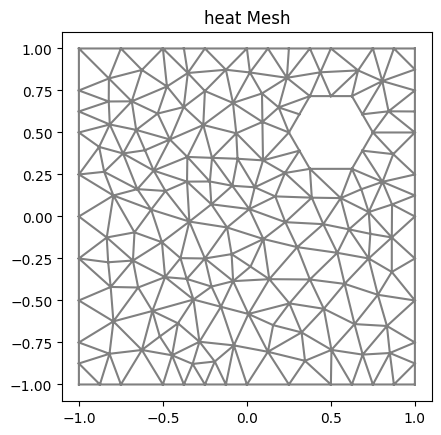

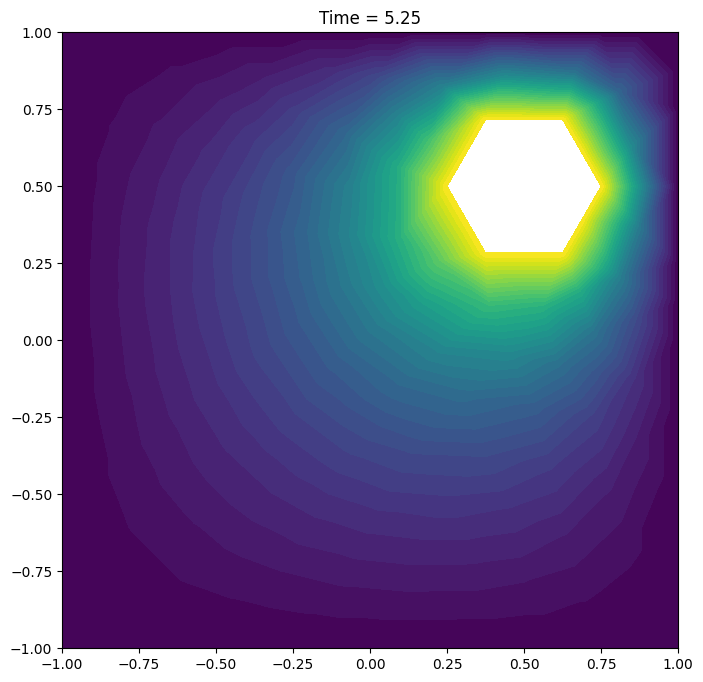

In [ ]:
from dolfin import *
from mshr import *
#
# heat_implicit
#
import matplotlib.pyplot as plt
#
#  Define the domain.
#
r_x = 0.5
r_y = 0.5
r_r = 0.25
#
domain = Rectangle(Point(-1.0,-1.0), Point(1.,1.)) - Circle(Point(r_x,r_y),r_r)
#
#  Mesh the domain.
#
mesh = generate_mesh ( domain, 10 )
#
#  Plot the mesh.
#
plot ( mesh, title = 'heat Mesh' )
#
#  Define the function space.
#
V = FunctionSpace ( mesh, "Lagrange", 1 )
#
#  Define the boundary conditions.
#
Tol = DOLFIN_EPS
u_D1 = 10.0
#
def ext ( x, on_boundary ):
    return ( on_boundary and ( (abs( x[0]-1.0 ) < Tol) or
                              (abs( x[0]+1.0 ) < Tol) or
                              (abs( x[1]-1.0 ) < Tol) or
                              (abs( x[1]+1.0 ) < Tol) ) )
#
bc1 = DirichletBC ( V, u_D1, ext )
#
u_D2 = 100.0
#
def inter ( x, on_boundary ):
    r = sqrt ( ( x[0] - r_x ) ** 2 + ( x[1] - r_y ) ** 2 )
    return ( on_boundary and ( r < r_r * 1.1 ) )
#
bc2 = DirichletBC ( V, u_D2, inter )
#
bc = [bc1, bc2 ]
#
#  The data
#
k = Constant ( 1.0 )
f = Constant ( 0.0 )
#
#  Define time
#
t_init = 0.0  #  The initial time.
t_final = 5.0 #  The final time.
t_num = 20    #  The number of step
dt = ( t_final - t_init ) / t_num  # The step size
#
#  The initial condition
#
u_init = Expression ( "40.0", degree = 10 )
u_old = interpolate ( u_init, V )
#
#  Define the bilinear form and the linear form..
#  Define the trial functions (u) and test functions (v).
#
u = TrialFunction ( V )
v = TestFunction ( V )
L = ( u_old + dt * f ) * v * dx
a = u * v * dx + dt * dot ( grad(u), grad(v) ) * dx
#
u = Function ( V )
#
#  The initial time.
#
t = t_init
#
#  Time loop.
#
for j in range ( 0, t_num + 1 ):
#
#  Update  the time
#
    t = t + dt
#
#  Solution of the variational problem a(u,v) = L(v).
#
    solve ( a == L, u, bc )
#
#  #  Update  U_OLD
#
    u_old.assign ( u )
#
# plot solution of the last stesp
#
plt.figure(figsize=(12,8))
label = 'Time = %g' % ( t )
plot(u,title = label)

# Solution:  Explicit method

## Explicit time-discretization of the heat equation

Let superscript $(n)$ denote a quantity at time $t_n$, where $n$ is an integer counting time levels. For example, $u^{(n)}$ means $u(t_n)$ at time level $n$.

A finite difference discretization in time first consists of sampling the PDE at some time level, say $t_{n}$:
$$
\left({\partial u \over\partial t}\right)^{(n)} - \kappa \Delta u^{(n)} = f^{(n)} \tag{4}$$

The forward difference approximation gives an approximation for the derivative $\partial u \over\partial t$ at time $t_n$ as:

\begin{equation}
{{u^{(n+1)} - u^{(n)}}\over{\Delta t}} = \kappa \Delta u^{(n)} + f^{(n)}. \tag{5}
\end{equation}

This is our time-discrete version of the heat equation (1), a so-called **forward Euler** or
**explicit Euler** discretization.

We may reorder (6) so that the left-hand side contains the terms with the unknown $u^{(n+1)}$ and
the right-hand side contains computed terms only. The result is a sequence of spatial (stationary) problems for $u^{(n+1)}$, assuming $u^{(n)}$ is known from the previous time step:

\begin{align}
u^{(0)} &= u_0,\tag{6a}\\
u^{(n+1)} & = u^{(n)} + {\Delta t} \kappa \Delta u^{(n)} +  {\Delta t} f^{(n)},\quad n = 0,1,2,\ldots  \tag{6b}
\end{align}

At each time step, we use a finite element method to solve (6.b). This requires turning the equations into weak forms.  As usual, we multiply by a test function $v \in V_0 = \left\{ u \in H^1(\Omega)  | u = 0 \text{ on } \partial \Omega\right\}$:

$$
\int_\Omega u^{(n+1)}v dx  = {\Delta t} \int_\Omega \nabla.(\kappa \nabla u^{(n)}) v dx  +  \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n)} v dx,
$$

and integrate second-derivatives by parts:

$$
 \int_\Omega u^{(n+1)}v dx = - {\Delta t} \bigg(\int_\Omega \kappa \nabla u^{(n)}\cdot \nabla v dx -
\int_{\partial\Omega}\kappa\frac{\partial u^{(n)}}{\partial n}v ds \bigg) + \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n)} v dx,
$$

Finally by recalling that $ v = 0 $ on $\partial \Omega$ and inserting the boundary conditions, we obtain:

$$
 \int_\Omega u^{(n+1)}v dx = - {\Delta t} \bigg(\int_\Omega \kappa \nabla u^{(n)}\cdot \nabla v dx + \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n)} v dx,
$$

The resulting weak form arising from formulation (6.b) can be written in the standard notation:

\begin{equation}
\text{ Find } \quad u = u^{(n+1)} \in   V_{u_D} = \left\{ u \in H^1(\Omega)  | u = u_D \text{ on } \partial \Omega \right\} \text{ such that: }\\
a(u,v)=L_{n}(v), \forall v \in V_0,
\end{equation}
where

\begin{align}
a(u,v) &= \int_\Omega uv  \mbox{d}x ,\\
L_{n}(v) &= \int_\Omega \left(u^{(n)} + {\Delta t}  f^{(n)} \right)v \mbox{d}x - {\Delta t} \int_\Omega \kappa \nabla u^{(n)}\cdot \nabla v dx.
\end{align}

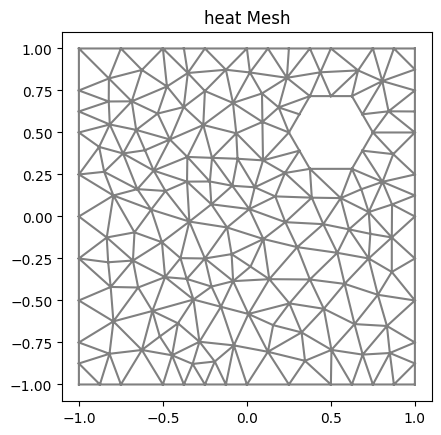

In [ ]:
#
from dolfin import *
from mshr import *
#
import matplotlib.pyplot as plt
# heat_explicit
#
#  Define the domain.
#
r_x = 0.5
r_y = 0.5
r_r = 0.25
domain = Rectangle(Point(-1.,-1.), Point(1.,1.)) - Circle(Point(r_x,r_y),r_r)
#
#  Mesh the domain.
#
mesh = generate_mesh ( domain, 10 )
#
#  Plot the mesh.
#
plot ( mesh, title = 'heat Mesh' )

In [ ]:
#
#  Define the function space.
#
V = FunctionSpace ( mesh, "Lagrange", 1 )
#
#  Define the boundary conditions.
#
Tol = DOLFIN_EPS
u_D1 = 10.0
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
      return ( on_boundary and ( (abs( x[0]-1.0 ) < Tol) or
                               (abs( x[0]+1.0 ) < Tol) or
                               (abs( x[1]-1.0 ) < Tol) or
                               (abs( x[1]+1.0 ) < Tol) ) )
ext = Bottom()

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

boundaries.set_all(0)

bc1 = DirichletBC ( V, u_D1, ext )

u_D2 = 100.0

def inter ( x, on_boundary ):
    r = sqrt ( ( x[0] - r_x ) ** 2 + ( x[1] - r_y ) ** 2 )
    return ( on_boundary and ( r < r_r * 1.1 ) )

bc2 = DirichletBC ( V, u_D2, inter )
#
bc = [bc1, bc2 ]
#

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_bb34ef50fc38033d098b2f0ee9bfd6dac5781091

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_26, f_29, f_30]'
  Unique elements:           'CG1(?,?), R0(?,?), CG3(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), CG3(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00798655 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0196733 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00586963 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0176113 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_780eb9ddb42feb9c6996c1225460f0d8c3f18bb9

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00508046 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0252488 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0076673 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0191264 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7814e45f852dd4e7d56a3c2bda58fd4c1abb4004

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0347798 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

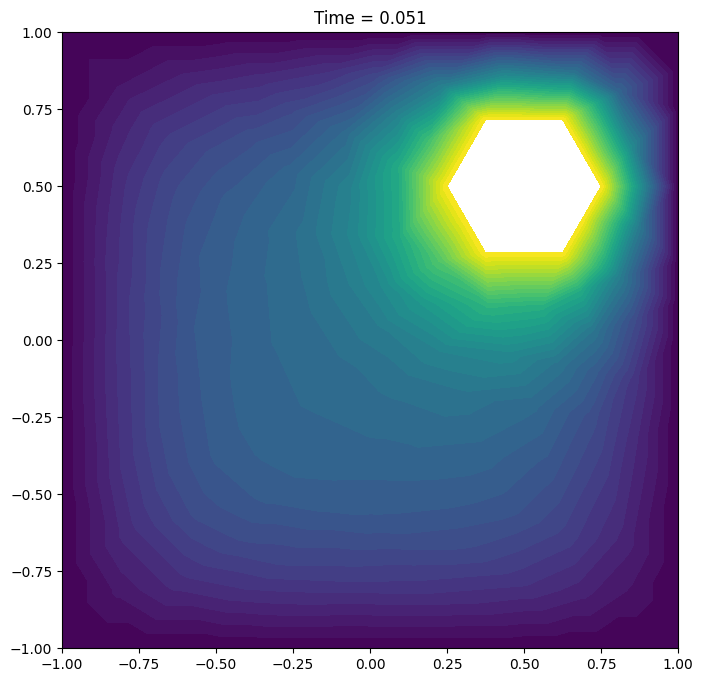

In [ ]:
#
#  The trial functions (u) and test functions (v).
#
u = TrialFunction ( V )
v = TestFunction ( V )
uold = Function ( V )  #  UOLD must be a Function.
#
#  Define the bilinear form.
#
a = inner ( u, v ) * dx
#
#  The diffusivity is a constant.
#
k = Constant ( 1.0 )
f = Expression ( "0.0", degree = 3 )
#
#  Define time
#
t_init = 0.0   #  The initial time.
t_final = 0.05 #  The final time.
t_num = 50     #  The number of step.
dt = ( t_final - t_init ) / t_num   #  The step size.
#
#  The initial condition
#
u_init = Expression ( "40.0", degree = 3 )
u = interpolate ( u_init, V )
#
#  The initial time.
#
t = t_init
#
#  Time loop.
#
for j in range ( 0, t_num + 1 ):
#
#  Update UOLD
#
    uold.assign ( u )
#
#  Update  the right hand side.
#
    L = inner ( uold, v ) * dx - dt * k * inner ( grad ( uold ), grad ( v ) ) * dx + dt * inner ( f, v ) * dx
#
#  Solution of the variational problem a(u,v) = L(v).
#
    solve ( a == L, u, bc )
#
#  Update  the time
#
    t = t + dt
# plot solution of the last step
plt.figure(figsize=(12,8))
label = 'Time = %g' % ( t )
plot(u,title = label)

## Excercise:

We will be interested in solving heat equation:

\begin{align*}
    u_t - \kappa \Delta u &= f,
        &&\quad\text{ in }\Omega\times(0, T), \tag{1}\\
     u &= u_D,
        &&\quad\text{ on }\partial\Omega\times(0, T),\tag{2}\\
    u &= u_0,
        &&\quad\text{ on }\Omega\times\{0\},\tag{3}
\end{align*}

using $\theta$-scheme discretization in time and arbitrary FE discretization
in space with given data $f$, $g$, $u_0$. $\theta$-scheme time-discrete heat equation reads:

Given $u_0$, we can solve for $u^1$, $u^2$,..,$u^n$, $u^{n+1}$,... :

\begin{align}
\begin{aligned}
\frac{1}{\Delta t} \Bigl(u^{n+1} - u^n\Bigr)
- \theta \kappa \Delta u^{n+1} - (1-\theta)\kappa \Delta u^n
&= \theta f(t_{n+1}) + (1-\theta) f(t_n),
    &&\quad\text{ in }\Omega, \; n=0,1,2,\ldots \\u^{n+1} &= u_D,
    &&\quad\text{ on }\partial\Omega, \; n=0,1,2,\ldots\\u^0 &= u_0,
    &&\quad\text{ in }\Omega
    \end{aligned}\tag{4}
    \end{align}
    
for a certain sequence $0=t_0 < t_1 < t_2 < ... \leq T$.

### Special cases for different values of $\theta$:

- When $\theta = 0$, this scheme is called as _explicit euler_ scheme. It means that by knowing the solution at $t = 0$ (initial condition), we can simply calculate what happens at $t + \Delta t$, and so on. The explicit schemes are generally known to be **unstable for larger time-steps** . The convergence rate is first-order $(\Delta t^{1}).$

- When $\theta = 1$, the scheme is called as _implicit euler_. The scheme is known to be unconditionally stable, but the convergence rate is the same as that of explicit euler.

- When $\theta = 0.5$, this scheme is called as  **Crank-Nicholson** method. The convergence rate in many cases could now go as $(\Delta t^2)$.




We may reorder (4) so that the left-hand side contains the terms with the unknown $u^{(n+1)}$ and
the right-hand side contains computed terms only. The result is a sequence of spatial problems for $u^{(n+1)}$, assuming $u^{(n)}$ is known from the previous time step:

$$
 \Bigl(u^{n+1} - u^n\Bigr)
- {\Delta t}\kappa \theta\Delta u^{n+1} - \kappa {\Delta t}(1-\theta)\Delta u^n
= {\Delta t}\theta f(t_{n+1}) + {\Delta t}(1-\theta) f(t_n) \tag{5}
$$

#### Algorithm:

Start with $u_0$ and choose a timestep ∆t > 0.
- For n = 0, 1, . . ., solve for $u^{(n+1)}$

$$
 u^{n+1} - {\Delta t}\kappa \theta \Delta u^{n+1}
= u^n + {\Delta t}\kappa(1-\theta)\Delta u^n + {\Delta t}\theta f(t_{n+1}) + {\Delta t}(1-\theta) f(t_n) \tag{6}
$$

## Solution
The Datas are as follows:

* $\Omega = [0, 1]\times[0, 1]$,

* $u_D(x, t) = 1 + x[0]*x[0] + \alpha*x[1]*x[1] + \beta*t$,

* $f = \beta - 2 - 2*\alpha$,

* $u_0 = u_D(x, 0)$.